In [17]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import os
from tqdm.notebook import tqdm
from IPython.display import clear_output

In [18]:
IMAGE_SIZE = 256
BATCH_SIZE = 32

In [21]:
# Define image transformations
transform = transforms.Compose([
    transforms.Resize((256, 256)),      # Resize images to 256x256
    transforms.ToTensor(),              # Convert images to PyTorch tensors
    transforms.Normalize(               # Normalize with ImageNet stats
        mean=[0.485, 0.456, 0.406], 
        std=[0.229, 0.224, 0.225]
    )
])

# Create dataset and dataloader
BATCH_SIZE = 32
dataset = datasets.ImageFolder("PlantVillage", transform=transform)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

# Get class names
class_names = dataset.classes
print("Class names:", class_names)
print("Number of classes:", len(class_names))
print("Dataset size:", len(dataset))

Class names: ['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']
Number of classes: 3
Dataset size: 2582


In [22]:
len(dataset)

2582

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0665298..2.1834733].


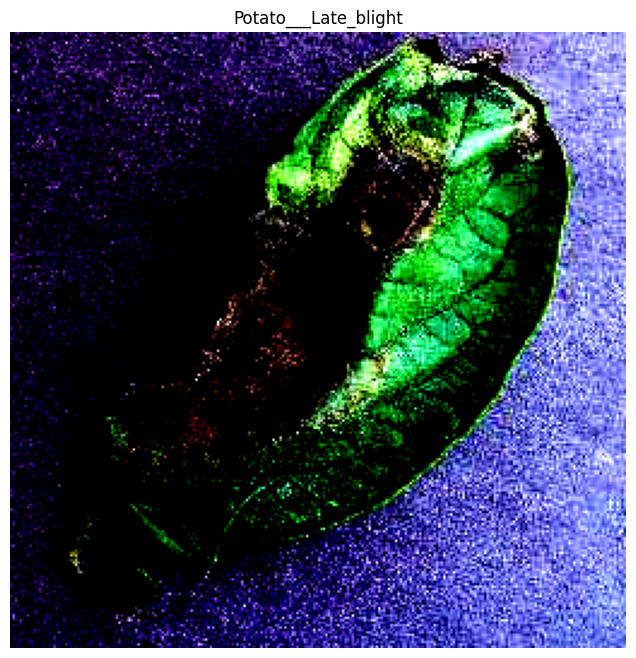

In [23]:
dataiter = iter(dataloader)
images, labels = next(dataiter)
plt.figure(figsize=(8, 8))
plt.imshow(images[0].permute(1, 2, 0))
plt.title(class_names[labels[0]])
plt.axis("off")
plt.show()

In [24]:
train_size = 0.8
len(dataset) * train_size

2065.6

In [25]:
total_size = len(dataset)
train_size = int(0.8 * total_size)
remaining = total_size - train_size
val_size = remaining // 2
test_size = remaining - val_size

generator = torch.Generator().manual_seed(42)
train_dataset, temp_dataset = random_split(
    dataset, 
    [train_size, remaining],
    generator=generator
)

val_dataset, test_dataset = random_split(
    temp_dataset,
    [val_size, test_size],
    generator=generator
)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Total samples: {total_size}")
print(f"Training samples: {len(train_dataset)} ({len(train_dataset)/total_size:.1%})")
print(f"Validation samples: {len(val_dataset)} ({len(val_dataset)/total_size:.1%})")
print(f"Test samples: {len(test_dataset)} ({len(test_dataset)/total_size:.1%})")

Total samples: 2582
Training samples: 2065 (80.0%)
Validation samples: 258 (10.0%)
Test samples: 259 (10.0%)


Epoch 15/15
Train Loss: 0.2204 | Acc: 0.9143
Val Loss: 0.1798 | Acc: 0.9419


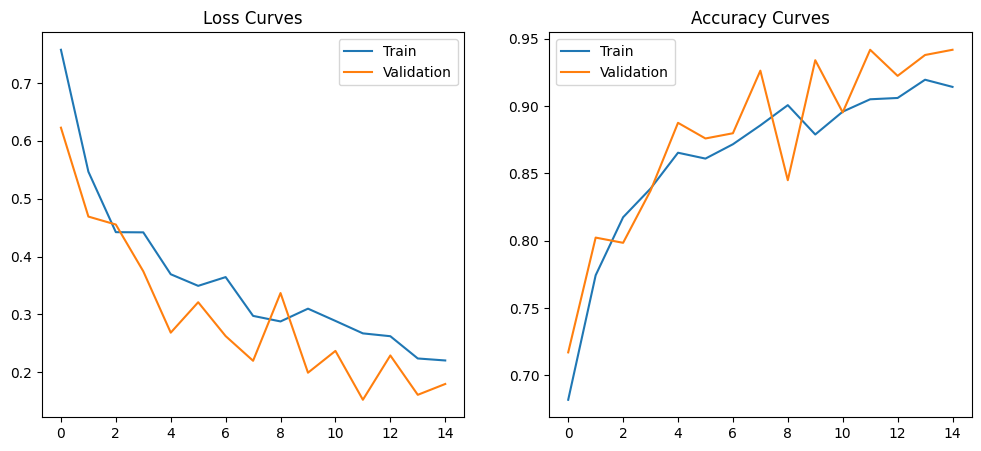

Testing:   0%|          | 0/9 [00:00<?, ?it/s]


Final Test Accuracy: 0.8842


In [116]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
EPOCHS = 15
NUM_CLASSES = 3
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(IMAGE_SIZE),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomGrayscale(p=0.05),
    transforms.GaussianBlur(kernel_size=5, sigma=(0.1, 2.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Dataset and DataLoaders
dataset = datasets.ImageFolder("PlantVillage", transform=train_transform)
class_names = dataset.classes
print(f"Class names: {class_names}")

train_size = int(0.8 * len(dataset))
val_size = (len(dataset) - train_size) // 2
test_size = len(dataset) - train_size - val_size

train_dataset, temp_dataset = random_split(
    dataset, [train_size, len(dataset)-train_size],
    generator=torch.Generator().manual_seed(42)
)

val_dataset, test_dataset = random_split(
    temp_dataset, [val_size, test_size],
    generator=torch.Generator().manual_seed(42)
)

# Apply different transforms to validation/test
val_dataset.dataset.transform = val_test_transform
test_dataset.dataset.transform = val_test_transform

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"\nDataset sizes:")
print(f"Train: {len(train_dataset)} samples")
print(f"Val: {len(val_dataset)} samples")
print(f"Test: {len(test_dataset)} samples")

# Model Definition
class PlantDiseaseCNN(nn.Module):
    def __init__(self, num_classes=len(class_names)):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2, 2),
            nn.Conv2d(128, 256, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2, 2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * (IMAGE_SIZE//16) * (IMAGE_SIZE//16), 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        return self.classifier(x)

model = PlantDiseaseCNN().to(DEVICE)
print("\nModel architecture:")
print(model)

# Training Setup
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
best_val_acc = 0.0
train_losses, val_losses = [], []
train_accs, val_accs = [], []

# Training Loop with Progress Bars
for epoch in range(EPOCHS):
    # Training Phase
    model.train()
    epoch_train_loss = 0.0
    correct = 0
    total = 0
    
    train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Train]")
    for images, labels in train_bar:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        epoch_train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        train_bar.set_postfix({
            'Loss': epoch_train_loss/(total/BATCH_SIZE),
            'Acc': correct/total
        })
    
    # Validation Phase
    model.eval()
    epoch_val_loss = 0.0
    val_correct = 0
    val_total = 0
    
    val_bar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Val]")
    with torch.no_grad():
        for images, labels in val_bar:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            epoch_val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
            
            val_bar.set_postfix({
                'Loss': epoch_val_loss/(val_total/BATCH_SIZE),
                'Acc': val_correct/val_total
            })
    
    # Calculate metrics
    train_loss = epoch_train_loss / len(train_loader)
    train_acc = correct / total
    val_loss = epoch_val_loss / len(val_loader)
    val_acc = val_correct / val_total
    
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    
    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_model.pth")
    
    # Clear output and show epoch results
    clear_output(wait=True)
    print(f"Epoch {epoch+1}/{EPOCHS}")
    print(f"Train Loss: {train_loss:.4f} | Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f} | Acc: {val_acc:.4f}")

# Plotting
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Validation')
plt.title('Loss Curves')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train')
plt.plot(val_accs, label='Validation')
plt.title('Accuracy Curves')
plt.legend()
plt.show()

# Test Evaluation
model.load_state_dict(torch.load("best_model.pth"))
model.eval()
test_correct = 0
test_total = 0

test_bar = tqdm(test_loader, desc="Testing")
with torch.no_grad():
    for images, labels in test_bar:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()
        test_bar.set_postfix({'Acc': test_correct/test_total})

print(f"\nFinal Test Accuracy: {test_correct/test_total:.4f}")


In [30]:
def check_image_properties(image_path):
    from PIL import Image
    img = Image.open(image_path)
    print(f"Format: {img.format}")
    print(f"Mode: {img.mode}")
    print(f"Size: {img.size}")
    return img

def predict_image(image_path):
    from PIL import Image
    
    # Load and preprocess the image exactly as was done during validation/testing
    image = Image.open(image_path).convert('RGB')  # Ensure RGB format
    
    # Use EXACTLY the same transformation as in val_test_transform
    transform = transforms.Compose([
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    # Transform and add batch dimension
    image_tensor = transform(image).unsqueeze(0).to(DEVICE)
    
    # Set model to evaluation mode
    model.eval()
    
    # Get prediction
    with torch.no_grad():
        outputs = model(image_tensor)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
        confidence, predicted_idx = torch.max(probabilities, 1)
        predicted_class = class_names[predicted_idx.item()]
        
    print(f"Prediction: {predicted_class} with {confidence.item()*100:.2f}% confidence")
    return predicted_class
print("\nSample prediction:")
print(predict_image("healthy.jpg"))
print(check_image_properties("healthy.jpg"))


Sample prediction:


NameError: name 'model' is not defined